In [6]:
import pyspark
from pyspark.sql.functions import *
from functools import reduce
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)


In [7]:
import matplotlib.pyplot as plt

In [8]:
#read dataset
df = spark.read.json('entities.ftm.json')


In [9]:
#divide dataset into smaller datasets grouping by type of entity

company_df = df.filter(df["schema"]=='Company')
person_df = df.filter(df["schema"]=='Person')
legal_entity_df = df.filter(df["schema"]=='LegalEntity')
directorship_df = df.filter(df["schema"]=='Directorship')
ownership_df = df.filter(df["schema"]=='Ownership')
organization_df = df.filter(df["schema"]=='Organization')
public_body_df = df.filter(df["schema"]=='PublicBody') 

In [383]:
#general number of registered companies in Estonia
company_df.distinct().count()

291340

In [384]:
#general number of company owners in Estonia
directors_df.distinct().count()

580686

In [39]:
#number of company owners per country (of origin)
#add graph
owners_per_country = person_df.select(person_df.properties.country.alias("country"),person_df.id)
owners_per_country = owners_per_country.withColumn("country", explode(col("country")))
owners_per_country = owners_per_country.groupBy("country").agg(countDistinct("id").alias("num_people"))
owners_per_country = owners_per_country.orderBy(col("num_people").desc())

#create pandas dataframe for plotting
owners_per_country_pd = owners_per_country.toPandas()
#print country with biggest number of company owners in dataset(obviously)
owners_per_country_pd.iloc[[0]]

,country,num_people
0,ee,247464


In [40]:
#selecting next top 10 counties with biggest number of company owners 
top_countries = owners_per_country_pd.iloc[1:11]

top_countries

,country,num_people
1,fi,4809
2,ua,4357
3,ru,3847
4,es,3206
5,lv,2951
6,de,2672
7,gb,1574
8,tr,1536
9,se,1490
10,pl,1381


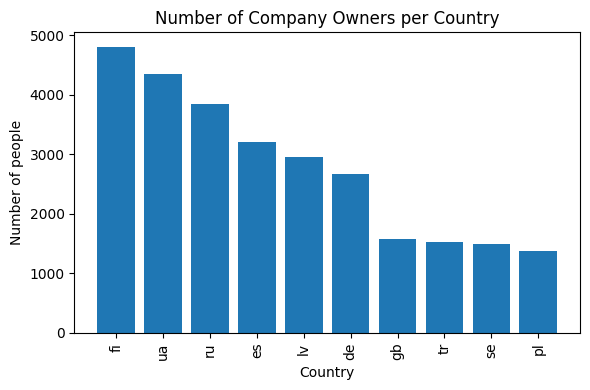

In [43]:
#plotting the results

plt.figure(figsize=(6, 4))
plt.bar(top_countries['country'], top_countries['num_people'])
plt.xlabel('Country')
plt.ylabel('Number of people')
plt.title('Number of Company Owners per Country')
plt.xticks(rotation=90) 
plt.tight_layout()

# show the plot
plt.show()

In [370]:
#show numbers of companies for each status
company_df.groupBy("properties.status").count().sort(col("count").desc()).show()

#Registrisse kantud - Registered
#Likvideerimisel - In liquidation
#Pankrotis - Bankrupt

+--------------------+------+
|              status| count|
+--------------------+------+
|[Registrisse kantud]|284330|
|   [Likvideerimisel]|  6422|
|         [Pankrotis]|   588|
+--------------------+------+



In [111]:
# data transformation for plotting 
company_status_df = company_df.select(company_df.properties.status.alias("status"), company_df.id)
company_status_df = company_status_df.withColumn("status", company_status_df.status.cast('string'))
company_status_df = company_status_df.withColumn("status", regexp_replace(company_status_df.status,   '\\[|\\]' , ''));
company_status_df = company_status_df.withColumn(
    "status",
    when(col("status") == "Registrisse kantud", "Registered")
    .when(col("status") == "Likvideerimisel", "In Liquidation")
    .when(col("status") == "Pankrotis", "Bankrupt")
    .otherwise(col("status"))
)

In [112]:
company_status_df = company_status_df.groupBy("status").agg(countDistinct("id").alias("companies"))
company_status_pd = company_status_df.toPandas()
company_status_pd.head()

,status,companies
0,In Liquidation,6422
1,Bankrupt,588
2,Registered,284330


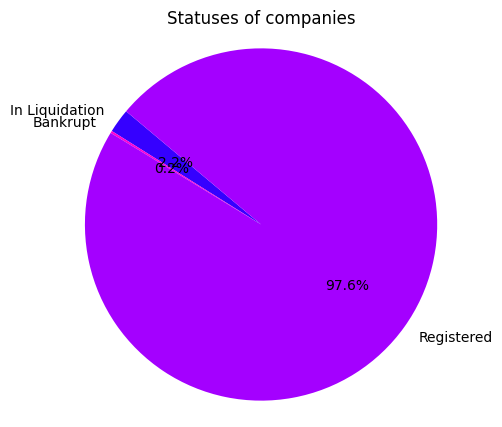

In [123]:
# plot pie chart
plt.figure(figsize=(5, 5))
plt.pie(company_status_pd['companies'], labels=company_status_pd['status'], autopct='%1.1f%%', startangle=140, colors=[ '#3500ff', '#ff00d3','#a400ff'])
plt.title('Statuses of companies')
plt.axis('equal')  
plt.show()

In [44]:
#count number of companies for each legal form
company_df.groupBy("properties.legalForm").count().sort(col("count").desc()).show(truncate=False)

+--------------------------------------------------------------------------------+------+
|legalForm                                                                       |count |
+--------------------------------------------------------------------------------+------+
|[Osaühing]                                                                      |256780|
|[Korteriühistu]                                                                 |24904 |
|[Usaldusühing]                                                                  |3814  |
|[Aktsiaselts]                                                                   |2238  |
|[Tulundusühistu]                                                                |1528  |
|[Täisühing]                                                                     |1281  |
|[Välismaa äriühingu filiaal]                                                    |477   |
|[Ametiühing]                                                                    |172   |
|[Maaparan

# Lets find 5 people who own biggest number of companies 

In [48]:
#select main columns from persons, clean the data 
p_df = person_df.select(person_df.id, person_df.properties.lastName.alias("lastName"), person_df.properties.firstName.alias('firstName'));
p_df = p_df.withColumn("lastName", p_df.lastName.cast('string')).withColumn("firstName", p_df.firstName.cast('string'));
p_df = p_df.withColumn("lastName", regexp_replace(p_df.lastName,   '\\[|\\]' , '')).withColumn("firstName", regexp_replace(p_df.firstName,   '\\[|\\]' , ''));


In [46]:
#select main columns from directorships, clean the data 

d_df = directorship_df.select(directorship_df.properties.organization.alias('organization_id'),
                              directorship_df.properties.director.alias('director_id'))
d_df = d_df.withColumn("director_id", d_df.director_id.cast('string')).withColumn("organization_id", d_df.organization_id.cast('string'));
d_df = d_df.withColumn("director_id", regexp_replace(d_df.director_id,   '\\[|\\]' , '')).withColumn("organization_id", regexp_replace(d_df.organization_id,   '\\[|\\]' , ''));


In [49]:
#select main columns from companies, clean the data 
c_df = company_df.select(company_df.id, company_df["properties.name"]);
c_df = c_df.withColumn("name", c_df.name.cast('string'));
c_df = c_df.withColumn("name", regexp_replace(c_df.name,   '\\[|\\]' , ''));

In [50]:
#join persons with directorship to get more information about 
directors_df = d_df.join(p_df,d_df.director_id == p_df.id,'inner')
directors_df = directors_df.withColumnRenamed("id", "owner_id")

In [69]:
companies_and_directors = directors_df.join(c_df,directors_df.organization_id == c_df.id,'inner')
companies_and_directors = companies_and_directors.drop('owner_id').drop('organization_id')
companies_and_directors = companies_and_directors.withColumnRenamed("id", "company_id")

companies_and_directors.show(5)

+--------------------+--------+---------+-----------+--------------------+
|         director_id|lastName|firstName| company_id|                name|
+--------------------+--------+---------+-----------+--------------------+
|      ee-46405046520|   Kiilo|     Kaja|ee-10000461|   Osaühing "Muaree"|
|      ee-46405256517|  Joakit|   Katrin|ee-10000461|   Osaühing "Muaree"|
|      ee-47311066528|    Vois|    Leila|ee-10000461|   Osaühing "Muaree"|
|      ee-36009300219|  Proosa|     Jüri|ee-10000515|Osaühing B.Braun ...|
|ee-officer-mia-ek...|  Eklund|      Mia|ee-10000515|Osaühing B.Braun ...|
+--------------------+--------+---------+-----------+--------------------+
only showing top 5 rows



In [52]:
# Count people who own biggest number of companies 

people_companies_count = companies_and_directors.groupBy("firstName", "lastName", "director_id") \
    .agg(countDistinct("company_id").alias("num_companies"))

# order the result in descending order based on the count of companies
people_companies_count = people_companies_count.orderBy(col("num_companies").desc())


In [382]:
# top individuals with the biggest number of companies associated with them
people_companies_count.show(truncate=False)

+--------------------------+----------------------+--------------+-------------+
|firstName                 |lastName              |director_id   |num_companies|
+--------------------------+----------------------+--------------+-------------+
|Lauri, Omanikukonto: Lauri|Hansberg              |ee-38305114217|472          |
|Raul                      |Pint                  |ee-36809224228|402          |
|Annika                    |Madissoon             |ee-48409055216|276          |
|Irina                     |Somova                |ee-45405260290|217          |
|Darja                     |Lissovskaja           |ee-48201173719|203          |
|Deniss                    |Godenko               |ee-38202013719|201          |
|Elvira                    |Sokolova              |ee-46502092735|200          |
|Külli                     |Niinoja               |ee-45205300259|194          |
|Roman                     |Buglevski             |ee-38404062718|181          |
|Hannes                    |

In [59]:
company_df.select(company_df.properties.incorporationDate).show(5)

+----------------------------+
|properties.incorporationDate|
+----------------------------+
|                [1995-09-14]|
|                [1995-09-14]|
|                [1995-09-27]|
|                [1995-09-27]|
|                [1995-09-26]|
+----------------------------+
only showing top 5 rows



#Count number of companies opened yearly

In [92]:
company_year_df = company_df.select(company_df.id, company_df["properties.incorporationDate"].alias("date"), company_df["properties.name"].alias("name"));
company_year_df = company_year_df.withColumn("date", company_year_df.date.cast('string')).withColumn("name", company_year_df.name.cast('string'));
company_year_df = company_year_df.withColumn("date", regexp_replace(company_year_df.date,   '\\[|\\]' , '')).withColumn("name", regexp_replace(company_year_df.name,   '\\[|\\]' , ''));
company_year_df.show(5, truncate=False);

+-----------+----------+---------------------------------------------+
|id         |date      |name                                         |
+-----------+----------+---------------------------------------------+
|ee-10000018|1995-09-14|Amserv Auto Osaühing, Amserv Auto Aktsiaselts|
|ee-10000024|1995-09-14|osaühing "Eesti Raamat"                      |
|ee-10000082|1995-09-27|Täisühing Grotte                             |
|ee-10000127|1995-09-27|Täisühing Aravete Apteek                     |
|ee-10000165|1995-09-26|Aktsiaselts Kiviõli Kaubahoov                |
+-----------+----------+---------------------------------------------+
only showing top 5 rows



In [93]:
company_year_df = company_year_df.withColumn("date", company_year_df["date"].cast('date'));

# extract year from the date column
company_year_df = company_year_df.withColumn("year", year(company_year_df["date"]))


company_year_df = company_year_df.groupBy("year").agg(countDistinct("id").alias("companies"))
company_year_df = company_year_df.orderBy(col("companies").desc())

#create pandas dataframe for plotting
company_year_pd = company_year_df.toPandas()
#print top 5 years during which the biggest number of companies opened
company_year_pd = company_year_pd.astype({'year': 'Int64'})
company_year_pd.head()

,year,companies
0,2018,26728
1,2023,22183
2,2021,21917
3,2022,19620
4,2019,18337


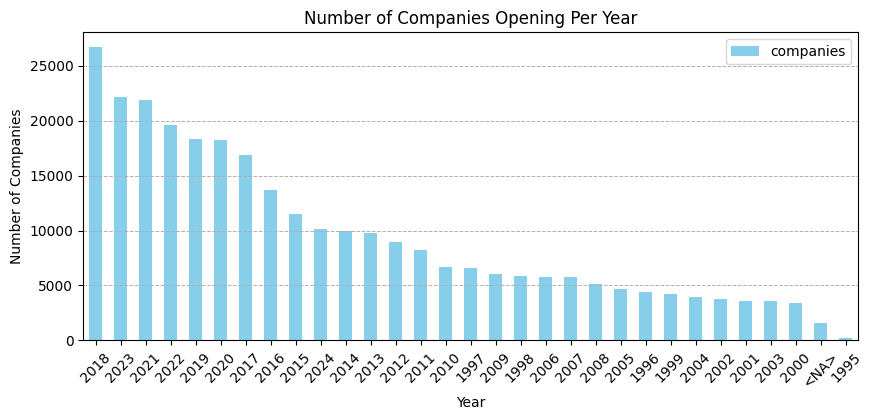

In [99]:
# create a bar plot using pandas and matplotlib
company_year_pd.plot(kind="bar", x = "year", y = "companies", figsize=(10, 4), color='skyblue')
plt.title("Number of Companies Opening Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Companies")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()